In [5]:
import numpy as np
from abipy import abilab
abilab.enable_notebook()

import abipy.flowtk as flowtk
import abipy.data as abidata
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Total energy

## Computing

In [2]:
def build_ngkpt_flow():
    ngkpt_list = [
        (2,2,2),
        (4,4,4),
        (6,6,6),
        (8,8,8),
    ]
    shiftk = [
        0.5, 0.5, 0.5,
        0.5, 0.0, 0.0,
        0.0, 0.5, 0.0,
        0.0, 0.0, 0.5,
    ]
    structure = abilab.Structure.from_abivars(
        ntype = 1,
        znucl = 14,
        natom = 2, # 2 atoms in a primitive sell
        typat = (1,1),
        acell = (10.18, 10.18, 10.18),
        rprim = [
            0.0, 0.5, 0.5,
            0.5, 0.0, 0.5,
            0.5, 0.5, 0.0,
        ],
        xred = [
            0.0, 0.0, 0.0,
            0.25, 0.25, 0.25
        ]
    )
    pseudos = "/home/denis/abinit-10.0.7.1-2d3c4/tests/Psps_for_tests/Pseudodojo_nc_sr_04_pw_standard_psp8/Si.psp8"
    multi = abilab.MultiDataset(
        structure=structure,
        pseudos=pseudos,
        ndtset=len(ngkpt_list),
    )
    multi.set_vars(
        ecut = 8,
        toldfe = 1.0e-6,
        diemac = 12.0,
        iomode = 3,
    )
    for i, ngkpt in enumerate(ngkpt_list):
        multi[i].set_kmesh(
            ngkpt = ngkpt,
            shiftk = shiftk,
        )
    workdir = "flow_base3_ngkpt"
    return flowtk.Flow.from_inputs(workdir, inputs=multi.split_datasets())

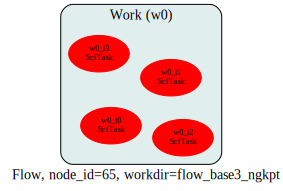

In [3]:
flow = build_ngkpt_flow()
flow.get_graphviz()

In [4]:
flow.make_scheduler().start()

Using scheduler v >= 3.0.0


[Sun Sep 29 14:42:46 2024] Number of launches: 2

Work #0: <Work, node_id=66, workdir=flow_base3_ngkpt/w0>, Finalized=False
+--------+-----------+-------------+--------------+------------+---------+-----------------+----------+-----------+
| Task   | Status    | Queue       | MPI|Omp|Gb   | Warn|Com   | Class   | Sub|Rest|Corr   | Time     |   Node_ID |
+========+===========+=============+==============+============+=========+=================+==========+===========+
| w0_t0  | Submitted | 20816@local | 1|  1|2.0    | 0|  0      | ScfTask | (1, 0, 0)       | 0:00:00Q |        67 |
+--------+-----------+-------------+--------------+------------+---------+-----------------+----------+-----------+
| w0_t1  | Submitted | 20818@local | 1|  1|2.0    | NA|NA      | ScfTask | (1, 0, 0)       | 0:00:00Q |        68 |
+--------+-----------+-------------+--------------+------------+---------+-----------------+----------+-----------+
| w0_t2  | Ready     | None        | 1|  1|2.0    | NA|NA      |

0

## Analisys

In [46]:
robot_energy_nkpt = abilab.GsrRobot.from_dir("flow_base3_ngkpt")
robot_table = robot_energy_nkpt.get_dataframe()
robot_table.sort_values(by='nkpt', inplace=True)
robot_table["energy_Ha"] = robot_table['energy'] * abilab.units.eV_to_Ha
robot_table["ediff_Ha"] = robot_table["energy_Ha"] - robot_table["energy_Ha"][-1]
robot_table[["nkpt", "energy_Ha", "ediff_Ha", "pressure", "max_force"]]

,nkpt,energy_Ha,ediff_Ha,pressure,max_force
w0/t0/outdata/out_GSR.nc,2,-8.514410,0.006320,-1.216656,7.513736e-30
w0/t1/outdata/out_GSR.nc,10,-8.520618,0.000112,-1.654687,0.000000e+00
w0/t2/outdata/out_GSR.nc,28,-8.520724,0.000006,-1.650842,0.000000e+00
w0/t3/outdata/out_GSR.nc,60,-8.520730,0.000000,-1.648005,0.000000e+00


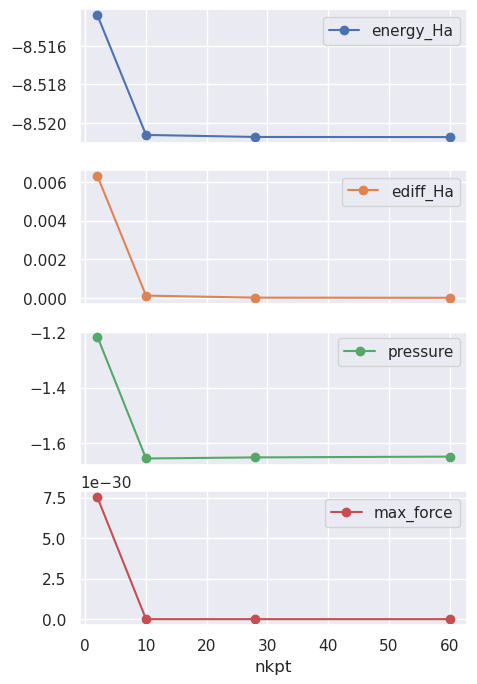

In [48]:
robot_table.plot(
    x = "nkpt",
    y = ["energy_Ha", "ediff_Ha", "pressure", "max_force"],
    style = '-o',
    subplots = True,
    figsize = (5,8)
);

## Results

Total energy is $-8.872$ a.u.

# Lattice parameters

## Computing

In [49]:
def build_relax_flow():
    ngkpt_list = [
        (2,2,2),
        (4,4,4),
    ]
    shiftk = [
        0.5, 0.5, 0.5,
        0.5, 0.0, 0.0,
        0.0, 0.5, 0.0,
        0.0, 0.0, 0.5,
    ]
    structure = abilab.Structure.from_abivars(
        ntype = 1,
        znucl = 14,
        natom = 2, # 2 atoms in a primitive sell
        typat = (1,1),
        acell = (10.18, 10.18, 10.18),
        rprim = [
            0.0, 0.5, 0.5,
            0.5, 0.0, 0.5,
            0.5, 0.5, 0.0,
        ],
        xred = [
            0.0, 0.0, 0.0,
            0.25, 0.25, 0.25
        ]
    )
    pseudos = "/home/denis/abinit-10.0.7.1-2d3c4/tests/Psps_for_tests/Pseudodojo_nc_sr_04_pw_standard_psp8/Si.psp8"
    multi = abilab.MultiDataset(
        structure=structure,
        pseudos=pseudos,
        ndtset=len(ngkpt_list),
    )
    multi.set_vars(
        ecut = 8,
        tolvrs = 1e-9,
        optcell = 1,
        ionmov = 3,
        ntime = 10,
        dilatmx = 1.05,
        ecutsm = 0.6,
        toldfe = 1.0e-6,
        diemac = 12.0,
        iomode = 3,
    )
    for i, ngkpt in enumerate(ngkpt_list):
        multi[i].set_kmesh(
            ngkpt = ngkpt,
            shiftk = shiftk,
        )
    workdir = "flow_base3_relax"
    return flowtk.Flow.from_inputs(workdir, inputs=multi.split_datasets())

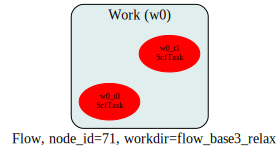

In [51]:
relax_flow = build_relax_flow()
relax_flow.get_graphviz()